# PL Attribution Starter Pack

**Not** guaranteed to be free of bugs.   Make sure to read and check the code if you use any of it.

In [1]:
import datetime
import logging
import copy

import pandas as pd
import numpy as np
import plotnine as p9


In [2]:
from ragtop.blackscholes import american, black_scholes
from ragtop.implicit import find_present_value, infer_conforming_time_grid, form_present_value_grid, integrate_pde, construct_implicit_grid_structure
from ragtop.instruments import ConvertibleBond, CallableBond
from ragtop.term_structures import spot_to_df_fcn, variance_cumulation_from_vols
from ragtop.extrapolation import spline_extrapolate



In [3]:
logging.basicConfig(level=logging.INFO,format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

logging.getLogger("ragtop").setLevel(logging.WARNING)

In [4]:
import os

# Set base directory for data files with a simple search for the data folder
possible_base_dirs = [
    os.getcwd(),
    os.path.abspath(os.path.join(os.getcwd(), 'SecurityPricing_CreditRisk')),
    os.path.abspath(os.path.join(os.getcwd(), '..', 'SecurityPricing_CreditRisk')),
    '/workspace/SecurityPricing_CreditRisk',
]
base_dir = None
for candidate in possible_base_dirs:
    if os.path.exists(os.path.join(candidate, 'data', 'Ford_Equity_July_2025.csv')):
        base_dir = candidate
        break

if base_dir is None:
    raise FileNotFoundError("Could not locate data directory containing Ford_Equity_July_2025.csv")

os.chdir(base_dir)
print(f"Working directory set to: {os.getcwd()}")


Working directory set to: /workspace/SecurityPricing_CreditRisk


## Relevant Data

In [5]:
f_equity = pd.read_csv('data/Ford_Equity_July_2025.csv', index_col="date",  parse_dates=True)
f_equity.reset_index(inplace=True)
f_equity.set_index(
    ['date', 'window_time'], inplace=True
)

f_median_trade_prices = pd.read_csv('data/Ford_Convert_Median_Mkt_Trade_July_2025.csv', index_col="date", parse_dates=True)

f_spreads3y = pd.read_csv('data/Ford_3Y_CDS_July_2025.csv', index_col="date", parse_dates=True)

f_vola = pd.read_csv('data/Ford_Vola_July_2025.csv', index_col="date", parse_dates=True)

yield_curves = pd.read_csv('data/YieldCurves_July_2025.csv', index_col="date", parse_dates=True)
f_spreads3y.iloc[[0,1,-2,-1]].transpose()


date,2025-07-11,2025-07-14,2025-07-24,2025-07-25
shortname,Ford Mtr Co,Ford Mtr Co,Ford Mtr Co,Ford Mtr Co
ticker,F,F,F,F
tier,SNRFOR,SNRFOR,SNRFOR,SNRFOR
runningcoupon,0.05,0.05,0.05,0.05
upfront,-0.099839,-0.099183,-0.098011,-0.097824
tenor,3Y,3Y,3Y,3Y
parspread,0.01363,0.01375,0.013858,0.013884
convspreard,0.013414,0.013534,0.01365,0.013673
cdsrealrecovery,0.4,0.4,0.4,0.4
cdsassumedrecovery,0.4,0.4,0.4,0.4


In [6]:
# Use the fact the data of spread3y is only over our relevant dates
# Some dates had no bond trades, so check those too
dates = [d for d in f_spreads3y.index if d in f_median_trade_prices.index]
', '.join([str(d.date()) for d in dates])

'2025-07-11, 2025-07-14, 2025-07-15, 2025-07-16, 2025-07-17, 2025-07-22, 2025-07-23, 2025-07-24'

In [7]:
f_equity

Unnamed: 0 ticker  best_bid  \
date       window_time                                              
2025-07-11 2025-07-11 10:00:00-04:00           0      F     11.80   
           2025-07-11 11:00:00-04:00           1      F     11.76   
           2025-07-11 12:00:00-04:00           2      F     11.73   
           2025-07-11 13:00:00-04:00           3      F     11.77   
           2025-07-11 14:00:00-04:00           4      F     11.80   
...                                          ...    ...       ...   
2025-07-25 2025-07-25 12:00:00-04:00           2      F     11.28   
           2025-07-25 13:00:00-04:00           3      F     11.32   
           2025-07-25 14:00:00-04:00           4      F     11.38   
           2025-07-25 15:00:00-04:00           5      F     11.41   
           2025-07-25 16:00:00-04:00           6      F     11.46   

                                      best_bidsizeshares  best_ask  \
date       window_time                                               
2025-07-11 2025-07-11 10:00:00-04:00               15800     11.81   
           2025-07-11 11:00:00-04:00               22300     11.77   
           2025-07-11 12:00:00-04:00               28300     11.74   
           2025-07-11 13:00:00-04:00               64200     11.78   
           2025-07-11 14:00:00-04:00               24600     11.81   
...                                                  ...       ...   
2025-07-25 2025-07-25 12:00:00-04:00               54300     11.29   
           2025-07-25 13:00:00-04:00               47700     11.33   
           2025-07-25 14:00:00-04:00               63500     11.39   
           2025-07-25 15:00:00-04:00               60800     11.42   
           2025-07-25 16:00:00-04:00               60300     11.47   

                                      best_asksizeshares  \
date       window_time                                     
2025-07-11 2025-07-11 10:00:00-04:00               11400   
           2025-07-11 11:00:00-04:00               23200   
           2025-07-11 12:00:00-04:00               25300   
           2025-07-11 13:00:00-04:00               30000   
           2025-07-11 14:00:00-04:00               24800   
...                                                  ...   
2025-07-25 2025-07-25 12:00:00-04:00               28000   
           2025-07-25 13:00:00-04:00               36200   
           2025-07-25 14:00:00-04:00               23400   
           2025-07-25 15:00:00-04:00               26600   
           2025-07-25 16:00:00-04:00              156200   

                                                       time_of_last_quote  \
date       window_time                                                      
2025-07-11 2025-07-11 10:00:00-04:00  2025-07-11 09:59:59.467910021-04:00   
           2025-07-11 11:00:00-04:00  2025-07-11 10:59:52.055819985-04:00   
           2025-07-11 12:00:00-04:00  2025-07-11 11:59:59.985827461-04:00   
           2025-07-11 13:00:00-04:00  2025-07-11 12:59:59.669392109-04:00   
           2025-07-11 14:00:00-04:00  2025-07-11 13:59:59.989697437-04:00   
...                                                                   ...   
2025-07-25 2025-07-25 12:00:00-04:00  2025-07-25 11:59:58.593159320-04:00   
           2025-07-25 13:00:00-04:00  2025-07-25 12:59:58.655898256-04:00   
           2025-07-25 14:00:00-04:00  2025-07-25 13:59:59.877015287-04:00   
           2025-07-25 15:00:00-04:00  2025-07-25 14:59:52.715604420-04:00   
           2025-07-25 16:00:00-04:00  2025-07-25 15:59:59.994574217-04:00   

                                      mid_equity_price  
date       window_time                                  
2025-07-11 2025-07-11 10:00:00-04:00            11.805  
           2025-07-11 11:00:00-04:00            11.765  
           2025-07-11 12:00:00-04:00            11.735  
           2025-07-11 13:00:00-04:00            11.775  
           2025-07-11 14:00:00-04:00            11.805  
...                                            

In [8]:
def mkt_data_for_date(d, is_morning=True):
    bond_trade_prices = f_median_trade_prices.loc[d]
    
    yc_in = yield_curves.loc[d]
    mktprice_today_in = bond_trade_prices['today_median']
    mktprice_tomorrow_in = bond_trade_prices['tomorrow_median']
    spread_in = f_spreads3y.loc[d]
    vola_in = f_vola.loc[d]
    equity_in = f_equity.loc[d].iloc[0 if is_morning else 4]
    
    return yc_in, mktprice_today_in, mktprice_tomorrow_in, spread_in, vola_in, equity_in

yc_in, mktprice_today_in, mktprice_tomorrow_in, spread_in, vola_in, equity_in = mkt_data_for_date('2025-07-14')
    


In [9]:
def inputs_for_date(d, is_morning=True, hazard_power=2, proportion_affected=0.5, dvola=0.01, dhazard=0.0002, dr=0.0001):
    if not isinstance(d, pd.Timestamp):
        d = pd.Timestamp(datetime.datetime.strptime(d, '%Y-%m-%d' ).date())
    
    yc_in, mktprice_today_in, mktprice_tomorrow_in, spread_in, vola_in, equity_in = mkt_data_for_date(d, is_morning=is_morning)
    
    # Risk free reates
    yield_curve = pd.DataFrame({'time':[30/360,90/360,180/360],'rate':yc_in.values})
    discounting_f = spot_to_df_fcn(yield_curve)
    
    yc_up   = spot_to_df_fcn(pd.DataFrame({'time':[30/360,90/360,180/360],'rate':(yc_in.values+dr)}))
    yc_down = spot_to_df_fcn(pd.DataFrame({'time':[30/360,90/360,180/360],'rate':(yc_in.values-dr)}))
    
    # Equity price
    S0 = equity_in['mid_equity_price']
    
    # Dividends (from Bloomberg BDVD)
    div_dates = [
        pd.Timestamp(datetime.date(2025, 8, 11)),
        pd.Timestamp(datetime.date(2025, 11, 7)),
        pd.Timestamp(datetime.date(2026, 2, 17)),
        pd.Timestamp(datetime.date(2026, 5, 11)),
    ]

    dividends = pd.DataFrame({
        "time": [(exd - d).days / 365 for exd in div_dates],
        "fixed": 0.15,       # fixed dollar amount per share
        "proportional": 0.0, # no proportional (percentage) dividend
    })

    # Optional: keep only future dividends within the horizon
    maturity = (pd.Timestamp("2026-03-15") - d).days / 365
    dividends = dividends[(dividends["time"] > 0) & (dividends["time"] < maturity)].copy()

    if dividends.empty:
        dividends = None       
    
    # Credit
    CDS_upfront = spread_in['upfront']
    CDS_parspread = spread_in['parspread']
    CDS_recov = spread_in['cdsassumedrecovery']
    hzd_rate  = CDS_parspread/(1-CDS_recov)
    logger.debug(f"Hazard rate: {hzd_rate:.5f}")
    
    # The ragtop library uses term structures to deal with risk free rates, hazard rrates and volatility
    
    def default_intensity_f(t,S,**kwargs):
        return hzd_rate * ((1-proportion_affected) + proportion_affected * (S0 / S) ** hazard_power)  
    
    def hzf_up_f(t,S,**kwargs):
        return (hzd_rate+dhazard) * ((1-proportion_affected) + proportion_affected * (S0 / S) ** hazard_power)
    
    def hzf_down_f(t,S,**kwargs):
        return (hzd_rate-dhazard) * ((1-proportion_affected) + proportion_affected * (S0 / S) ** hazard_power)
    
    # Vola
    vola_df = pd.DataFrame({
        'time': [int(colname)/360 for colname in vola_in.index],
        'volatility': vola_in.values,
    })
    variance_f = variance_cumulation_from_vols(vola_df)

    vola_df_down = pd.DataFrame({
        'time': vola_df['time'],
        'volatility': vola_df['volatility'].values - dvola,
    })
    variance_down_f = variance_cumulation_from_vols(vola_df_down)
    
    vola_df_up = pd.DataFrame({
        'time': vola_df['time'],
        'volatility': vola_df['volatility'].values + dvola,
    })
    variance_up_f = variance_cumulation_from_vols(vola_df_up)
       
    
    
    model_inputs = {
        'Underlying': S0,
        'Avg Trade Price Today': mktprice_today_in,
        'Avg Trade Price Tomorrow': mktprice_tomorrow_in,
        'Default Intensities': default_intensity_f,
        'Recovery Rate': CDS_recov,
        'Risk-free Rates': discounting_f,
        'Vola/Variance': variance_f,
        'Vola/Variance Up': variance_up_f,
        'Vola/Variance Down': variance_down_f,
        'Hazard Up':hzf_up_f,
        'Hazard Down':hzf_down_f,
        'Base Hazard Rate':hzd_rate,
        'Rates Up':yc_up,
        'Rates Down':yc_down,
        'Dividends': dividends,
    }    
    
    return model_inputs
inputs_for_date('2025-07-14')

{'Underlying': np.float64(11.735),
 'Avg Trade Price Today': np.float64(101.4674),
 'Avg Trade Price Tomorrow': np.float64(100.6773),
 'Default Intensities': <function __main__.inputs_for_date.<locals>.default_intensity_f(t, S, **kwargs)>,
 'Recovery Rate': np.float64(0.4),
 'Risk-free Rates': <function ragtop.term_structures.spot_to_df_fcn.<locals>.discount_factor_callable(T: 'float | NDArray[Any]', t: 'float | NDArray[Any]' = 0.0, **_: 'dict[str, Any]') -> 'NDArray[Any]'>,
 'Vola/Variance': <function ragtop.term_structures.variance_cumulation_from_vols.<locals>.var_cum(T: 'float | NDArray[Any]', t: 'float | NDArray[Any]' = 0.0) -> 'NDArray[Any]'>,
 'Vola/Variance Up': <function ragtop.term_structures.variance_cumulation_from_vols.<locals>.var_cum(T: 'float | NDArray[Any]', t: 'float | NDArray[Any]' = 0.0) -> 'NDArray[Any]'>,
 'Vola/Variance Down': <function ragtop.term_structures.variance_cumulation_from_vols.<locals>.var_cum(T: 'float | NDArray[Any]', t: 'float | NDArray[Any]' = 0.0

In [10]:
def compute_attribution_inputs(Tmax, inputs_dict):
    # Attribution parameters:
    # Help us work out day to day -- how much did rates, volatility, hazard change overall on their curves?
    
    r = -np.log(inputs_dict['Risk-free Rates'](Tmax)) / Tmax

    sigma0 = np.sqrt(inputs_dict['Vola/Variance'](Tmax)/Tmax)
    S0 = inputs_dict['Underlying']
    h = inputs_dict['Base Hazard Rate']  # not using curves here, at least for now
    # NB: Ignoring borrow cost / divrate
    
    attribution_inputs = {
        'Underlying Price':S0,
        'Avg Risk Free Rate' : r,
        'Avg Volatility' : sigma0,
        'Avg Hazard Rate' : h,
    }
    return attribution_inputs


On each date, we need to run the model not only to get price, but also do finite differences to get sensitivity to rates, default risk, volatility and so on

In [11]:
def run_model_for_date(d, is_morning=True, 
                       hazard_power=2, proportion_affected=0.75, 
                       dividend_rate=0, borrow_cost=0,  # Discrete divs will be from from inputs_for_date()
                       dvola=0.01, dhazard=0.0002,dr=0.0001,
                       n_steps=200, grid_stdevs_width=5):
    
    inputs_dict = inputs_for_date(d, is_morning=is_morning, 
                                  hazard_power=hazard_power, proportion_affected=proportion_affected, 
                                  dvola=dvola, dhazard=dhazard,dr=dr)
    S0 = inputs_dict['Underlying']
    
    maturity = (pd.Timestamp('2026-03-15') - d).days/365
    coups = None
    dconv = ConvertibleBond(
        coupons=coups,
        conversion_ratio=74.5103,
        maturity=maturity,
        calls=None,
        puts=None,
        notional=1000.0,
        recovery_rate=inputs_dict['Recovery Rate'],
        name="FordMarchOf2026",
    )
    
    straightbond = CallableBond(
        coupons=coups,
        maturity=maturity,
        calls=None,
        puts=None,
        notional=1000.0,
        recovery_rate=inputs_dict['Recovery Rate'],
        name="StraightBondEquivalent",
    )
    
    # Need dconv_u, dconv_d etc only for older ragtop without reset_caches() functionality
    dconv_u = copy.deepcopy(dconv)
    dconv_d = copy.deepcopy(dconv)
    dconv_ru = copy.deepcopy(dconv)
    dconv_rd = copy.deepcopy(dconv)
    dconv_hu = copy.deepcopy(dconv)
    dconv_hd = copy.deepcopy(dconv)
    Tmax = dconv.maturity
    K = dconv.notional / dconv.conversion_ratio

    attribution_inputs = compute_attribution_inputs(Tmax, inputs_dict)
    r      = attribution_inputs['Avg Risk Free Rate']
    sigma0 = attribution_inputs['Avg Volatility']       # <-- FIXED
    # sigma0 = attribution_inputs['Avg Risk Free Rate']
    c = r - dividend_rate - borrow_cost

    def stock_level_fcn(z, t):
        S_levels = K * np.exp(z - (c - 0.5 * sigma0**2) * (Tmax - t))
        return S_levels

    grid_structure = construct_implicit_grid_structure(
        tenors=[Tmax],
        M=n_steps,
        S0=S0,
        K=K,
        c=c,
        sigma=sigma0,
        structure_constant=2,
        std_devs_width=grid_stdevs_width,
    )

    time_pts = infer_conforming_time_grid(
        n_steps,
        Tmax,
        instruments=[dconv]
    )

    deltaT0 = T1 = time_pts[1]

    full_grid = integrate_pde(
        z=grid_structure["z"],
        min_num_time_steps=n_steps,
        S0=S0,
        Tmax=Tmax,
        instruments=[dconv, straightbond],
        stock_level_fcn=stock_level_fcn,
        discount_factor_fcn=inputs_dict['Risk-free Rates'],
        default_intensity_fcn=inputs_dict['Default Intensities'],   # <-- FIXED
        variance_cumulation_fcn=inputs_dict['Vola/Variance'],  # keep vol fixed
        dividends=inputs_dict['Dividends'],
    )
    
    S_T0 = stock_level_fcn(grid_structure["z"], 0.0)
    S_T1 = stock_level_fcn(grid_structure["z"], T1)


    V_T0 = full_grid[0, :, 0]
    V_T1 = full_grid[1, :, 0]
    
    deltaS = S0/100.0

    testS = np.array([S0-deltaS , S0, S0+deltaS])
    
    pv_interpolation = spline_extrapolate(S_T0, V_T0, testS)
    t1_interpolation = spline_extrapolate(S_T1, V_T1, np.array([S0], dtype=float))

    V0 = float(pv_interpolation[1])
    delta = float((pv_interpolation[2] - pv_interpolation[0])/(2*deltaS))
    gamma = float((pv_interpolation[2] - 2*V0 + pv_interpolation[0])/(deltaS**2))
    theta = float(((t1_interpolation[0] - V0)/deltaT0))
    
    straightbond_price = spline_extrapolate(S_T0, full_grid[0, :, 1], np.array([S0]))[0]
    premium = V0 - straightbond_price
    
    
    # Manual finite differencing to get other risk params
    
    v_vola_up = find_present_value(
        S0=S0, 
        instruments=[dconv_u],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Default Intensities'],
        discount_factor_fcn=inputs_dict['Risk-free Rates'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance Up'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- turn off dividends for bumped run
    )["FordMarchOf2026"]

    v_vola_down = find_present_value(
        S0=S0, 
        instruments=[dconv_d],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Default Intensities'],
        discount_factor_fcn=inputs_dict['Risk-free Rates'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance Down'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- same here
    )["FordMarchOf2026"]

    v_vola_up = float(np.squeeze(v_vola_up))
    v_vola_down = float(np.squeeze(v_vola_down))
    vega = (v_vola_up - v_vola_down) / (2 * dvola)


    # Vega block unchanged – it's correct

    v_hzd_up = find_present_value(
        S0=S0, 
        instruments=[dconv_hu],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Hazard Up'],
        discount_factor_fcn=inputs_dict['Risk-free Rates'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- no dividends in bump
    )["FordMarchOf2026"]

    v_hzd_down = find_present_value(
        S0=S0, 
        instruments=[dconv_hd],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Hazard Down'],
        discount_factor_fcn=inputs_dict['Risk-free Rates'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- same here
    )["FordMarchOf2026"]

    v_hzd_up = float(np.squeeze(v_hzd_up))
    v_hzd_down = float(np.squeeze(v_hzd_down))
    cdv01 = (v_hzd_up - v_hzd_down) / (2 * dhazard)


    v_rates_up = find_present_value(
        S0=S0, 
        instruments=[dconv_ru],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Default Intensities'],
        discount_factor_fcn=inputs_dict['Rates Up'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- no dividends in bump
    )["FordMarchOf2026"]

    v_rates_down = find_present_value(
        S0=S0, 
        instruments=[dconv_rd],
        num_time_steps=n_steps,
        default_intensity_fcn=inputs_dict['Default Intensities'],
        discount_factor_fcn=inputs_dict['Rates Down'],
        variance_cumulation_fcn=inputs_dict['Vola/Variance'],
        std_devs_width=grid_stdevs_width,
        dividends=None,  # <--- same here
    )["FordMarchOf2026"]

    v_rates_up = float(np.squeeze(v_rates_up))
    v_rates_down = float(np.squeeze(v_rates_down))
    rdv01 = (v_rates_up - v_rates_down) / (2 * dr)

    
    risk_params_dict = {'date':d, 'ModelPrice':V0, 'Tenor':Tmax,
                    'Delta':delta, 'Gamma':gamma, 'Theta':theta, 'Vega':vega, 'Rates DV01':rdv01, 'Credit DV01 (drifted)':cdv01,
                    'Convertibility Premium': premium,
                    'Avg Trade Price':inputs_dict['Avg Trade Price Today']*dconv.notional/100,
                   }
    
    overall_dict = risk_params_dict.copy()
    overall_dict.update(attribution_inputs)

    ps = pd.Series(overall_dict)
    
    return ps

run_model_for_date(pd.Timestamp('2025-07-14'), is_morning=True)

date                      2025-07-14 00:00:00
ModelPrice                        1008.399368
Tenor                                0.668493
Delta                               28.005967
Gamma                                9.371418
Theta                              -85.280616
Vega                               273.702541
Rates DV01                        -443.286076
Credit DV01 (drifted)             -221.681652
Convertibility Premium              46.663085
Avg Trade Price                      1014.674
Underlying Price                       11.735
Avg Risk Free Rate                   0.043827
Avg Volatility                       0.309414
Avg Hazard Rate                      0.022916
dtype: object

In [12]:
details_arc_list = [
    run_model_for_date(datadate) for datadate in dates
]
details_arc = pd.DataFrame(details_arc_list).set_index('date')
details_arc.iloc[[0,1,2,-2,-1]].transpose()

date,2025-07-11,2025-07-14,2025-07-15,2025-07-23,2025-07-24
ModelPrice,1011.153881,1008.399368,1008.899023,997.790208,999.695679
Tenor,0.676712,0.668493,0.665753,0.643836,0.641096
Delta,28.933944,28.005967,28.218607,23.621144,24.190044
Gamma,9.303612,9.371418,9.403856,9.142694,9.120169
Theta,-94.703905,-85.280616,-95.585673,-83.919563,-93.730981
Vega,280.957039,273.702541,274.377956,246.913202,249.899295
Rates DV01,-447.599036,-443.286076,-441.166250,-460.653333,-457.135181
Credit DV01 (drifted),-218.962423,-221.681652,-220.006211,-243.434071,-240.580144
Convertibility Premium,49.803490,46.663085,47.153574,34.844185,36.534878
Avg Trade Price,1012.805500,1014.674000,1006.773000,1002.213000,999.381000


## 2. Changes in Drivers (ΔS, ΔTenor, ΔAvgRate, ΔAvgVol, ΔAvgHazard)

In [13]:

# Ensure date is the index before sorting for differences
if 'date' in details_arc.columns:
    details_arc = details_arc.set_index('date')

# Sort by date to compute forward differences
details_arc = details_arc.sort_index()

# Compute changes in key drivers
driver_cols = ['Underlying Price', 'Tenor', 'Avg Risk Free Rate', 'Avg Volatility', 'Avg Hazard Rate']
driver_changes = details_arc[driver_cols].diff()
driver_changes.columns = ['dS', 'dTenor', 'dAvgRate', 'dAvgVol', 'dAvgHazard']

# Merge back into the core table
for col in driver_changes.columns:
    details_arc[col] = driver_changes[col]

# Quick inspection of original vs changes
details_arc[['Underlying Price', 'dS', 'Tenor', 'dTenor',
             'Avg Risk Free Rate', 'dAvgRate',
             'Avg Volatility', 'dAvgVol',
             'Avg Hazard Rate', 'dAvgHazard']].head(10)


,Underlying Price,dS,Tenor,dTenor,Avg Risk Free Rate,dAvgRate,Avg Volatility,dAvgVol,Avg Hazard Rate,dAvgHazard
date,,,,,,,,,,
2025-07-11,11.805,NaN,0.676712,NaN,0.043824,NaN,0.312097,NaN,0.022717,NaN
2025-07-14,11.735,-0.07,0.668493,-0.008219,0.043827,3.040944e-06,0.309414,-0.002683,0.022916,0.000199
2025-07-15,11.755,0.02,0.665753,-0.002740,0.043831,3.285752e-06,0.309738,0.000323,0.023254,0.000337
2025-07-16,11.325,-0.43,0.663014,-0.002740,0.043834,2.898651e-06,0.319260,0.009522,0.023866,0.000612
2025-07-17,11.235,-0.09,0.660274,-0.002740,0.043836,2.083287e-06,0.312826,-0.006433,0.023726,-0.000140
2025-07-22,11.155,-0.08,0.646575,-0.013699,0.043836,2.331651e-07,0.312708,-0.000118,0.023688,-0.000038
2025-07-23,11.325,0.17,0.643836,-0.002740,0.043830,-6.046006e-06,0.310372,-0.002336,0.023298,-0.000390
2025-07-24,11.365,0.04,0.641096,-0.002740,0.043825,-5.033151e-06,0.314693,0.004321,0.023096,-0.000202


## 3. P&L Attribution (Actual vs Explained)

Actual P&L is benchmarked to the observed TRACE median trade prices (Market PL). Model PL is computed for reference.

In [14]:

# Actual PL series
(details_arc['Model PL'], details_arc['Market PL']) = (
    details_arc['ModelPrice'].diff(),
    details_arc['Avg Trade Price'].diff(),
)

# Use start-of-interval Greeks to attribute P&L movements
shifted = details_arc.shift(1)

# Equity contribution with optional gamma term
PL_S_linear = shifted['Delta'] * details_arc['dS']
PL_S_gamma = 0.5 * shifted['Gamma'] * (details_arc['dS'] ** 2)
details_arc['PL_S'] = PL_S_linear + PL_S_gamma

# Rates contribution (DV01 per 1bp)
details_arc['PL_Rates'] = shifted['Rates DV01'] * (details_arc['dAvgRate'] / 0.0001)

# Volatility contribution
details_arc['PL_Vol'] = shifted['Vega'] * details_arc['dAvgVol']

# Theta contribution (time decay over tenor change)
details_arc['PL_Theta'] = shifted['Theta'] * details_arc['dTenor']

# Credit contribution via hazard changes
details_arc['PL_Credit'] = shifted['Credit DV01 (drifted)'] * (details_arc['dAvgHazard'] / 0.0001)

# Aggregate explained PL

details_arc['Explained PL (all drivers)'] = (
    details_arc['PL_S']
    + details_arc['PL_Rates']
    + details_arc['PL_Vol']
    + details_arc['PL_Theta']
    + details_arc['PL_Credit']
)

details_arc['Explained PL (stock only)'] = details_arc['PL_S']

details_arc[['Model PL', 'Market PL', 'Explained PL (all drivers)', 'Explained PL (stock only)']].head()


,Model PL,Market PL,Explained PL (all drivers),Explained PL (stock only)
date,,,,
2025-07-11,NaN,NaN,NaN,NaN
2025-07-14,-2.754513,1.8685,-451.616301,-2.002582
2025-07-15,0.499655,-7.9010,-761.376385,0.561994
2025-07-16,-9.041201,-6.9125,-1368.679326,-11.264615
2025-07-17,-3.387127,-2.9475,331.950905,-2.177882


### Hint check: Jul 15 → Jul 16 volatility contribution

In [15]:

import pandas as pd
import numpy as np

idx_15 = pd.Timestamp('2025-07-15')
idx_16 = pd.Timestamp('2025-07-16')

if idx_15 in details_arc.index and idx_16 in details_arc.index:
    vega_15 = details_arc.loc[idx_15, 'Vega']
    dvol_15_16 = details_arc.loc[idx_16, 'dAvgVol']
    pl_vol_15_16 = details_arc.loc[idx_16, 'PL_Vol']

    print("Vega (Jul 15):", vega_15)
    print("dAvgVol (15→16):", dvol_15_16)
    print("PL_Vol (15→16):", pl_vol_15_16)

    assert abs(details_arc.loc[idx_15, 'Avg Volatility'] - 0.309738) < 0.001, "Avg Vol on Jul 15 off expected ~0.309738"
    assert abs(dvol_15_16 - 0.009522) < 0.002, "dAvgVol 15→16 off expected ~0.0095"
    assert abs(pl_vol_15_16 - 2.53) < 1.0, "PL_Vol 15→16 off expected ~2.53"
else:
    print("July 15 or July 16 not present in index; cannot run hint check.")


Vega (Jul 15): 274.3779556538641
dAvgVol (15→16): 0.009522098274017787
PL_Vol (15→16): 2.612653857960188


## 4. Graphs and Analysis: Explained vs Actual PL

In [16]:

# Prepare tidy dataframe for plotting
import plotnine as p9

df_pl = details_arc.dropna(subset=['Market PL', 'Explained PL (all drivers)', 'Explained PL (stock only)']).copy()
df_pl = df_pl.reset_index().rename(columns={'index': 'date'})

df_pl.head()


,date,ModelPrice,Tenor,Delta,Gamma,Theta,Vega,Rates DV01,Credit DV01 (drifted),Convertibility Premium,...,dAvgHazard,Model PL,Market PL,PL_S,PL_Rates,PL_Vol,PL_Theta,PL_Credit,Explained PL (all drivers),Explained PL (stock only)
0,2025-07-14,1008.399368,0.668493,28.005967,9.371418,-85.280616,273.702541,-443.286076,-221.681652,46.663085,...,0.000199,-2.754513,1.8685,-2.002582,-13.611235,-0.753701,0.778388,-436.027171,-451.616301,-2.002582
1,2025-07-15,1008.899023,0.665753,28.218607,9.403856,-95.585673,274.377956,-441.166250,-220.006211,47.153574,...,0.000337,0.499655,-7.9010,0.561994,-14.565281,0.088522,0.233646,-747.695265,-761.376385,0.561994
2,2025-07-16,999.857821,0.663014,24.597167,8.854968,-84.042458,253.558175,-469.165216,-246.586891,38.245142,...,0.000612,-9.041201,-6.9125,-11.264615,-12.787868,2.612654,0.261879,-1347.501375,-1368.679326,-11.264615
3,2025-07-17,996.470694,0.660274,23.370718,8.911160,-84.179039,244.741349,-470.198930,-252.853211,34.634269,...,-0.000140,-3.387127,-2.9475,-2.177882,-9.774057,-1.631252,0.230253,345.303843,331.950905,-2.177882
4,2025-07-22,994.468471,0.646575,22.262789,8.858389,-73.628899,234.318055,-461.046165,-253.740463,31.841090,...,-0.000038,-2.002223,-0.1045,-1.841142,-1.096340,-0.028961,1.153138,95.915651,94.102347,-1.841142


### Scatter: all drivers vs actual PL

2025-11-24 20:49:59,740 - INFO - generated new fontManager


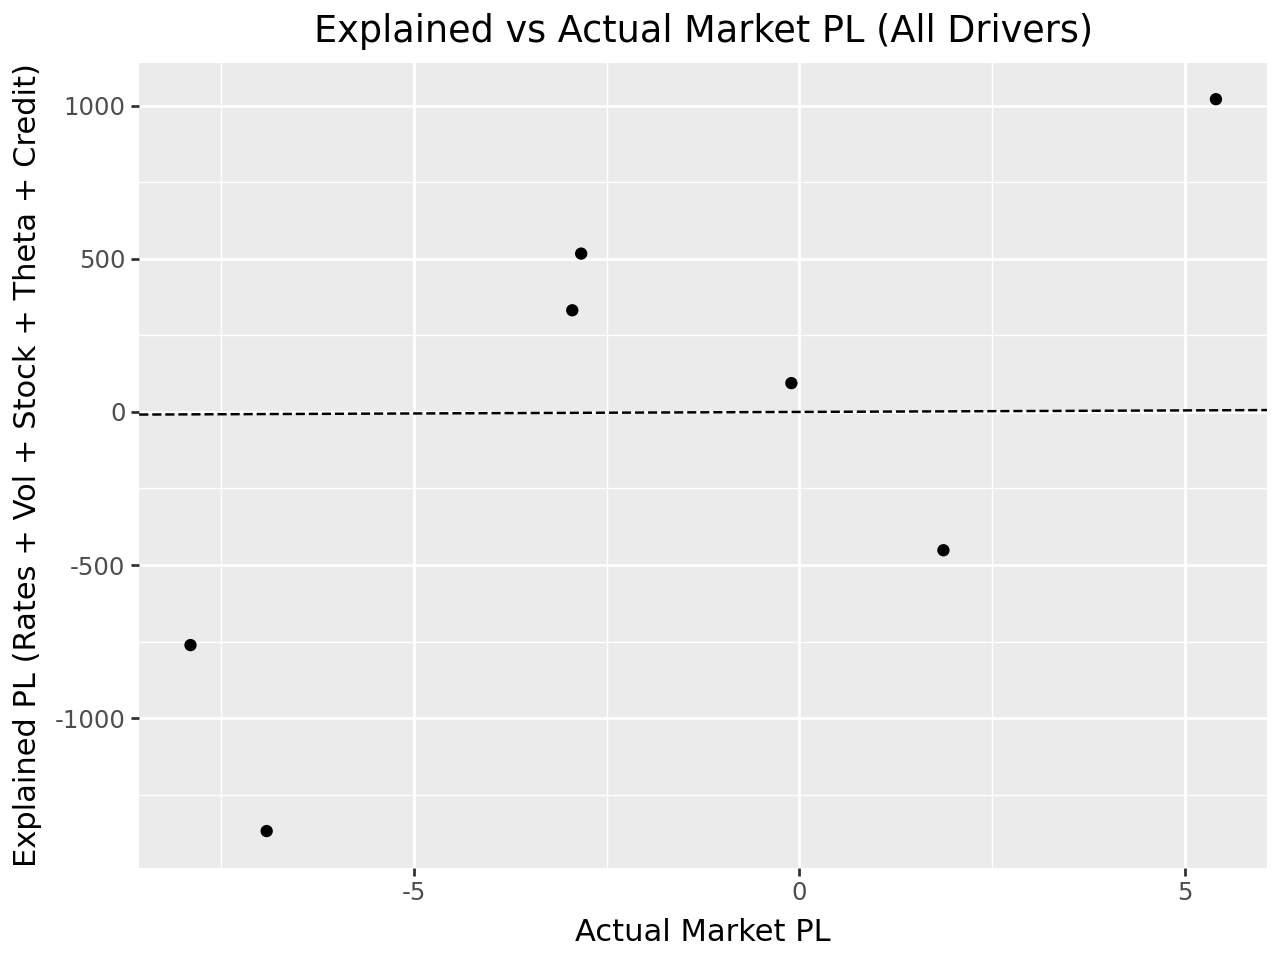

In [17]:

p_all = (
    p9.ggplot(df_pl, p9.aes(x='Market PL', y='Explained PL (all drivers)'))
    + p9.geom_point()
    + p9.geom_abline(slope=1, intercept=0, linetype='dashed')
    + p9.labs(
        title='Explained vs Actual Market PL (All Drivers)',
        x='Actual Market PL',
        y='Explained PL (Rates + Vol + Stock + Theta + Credit)'
    )
)
p_all


### Scatter: stock-only vs actual PL

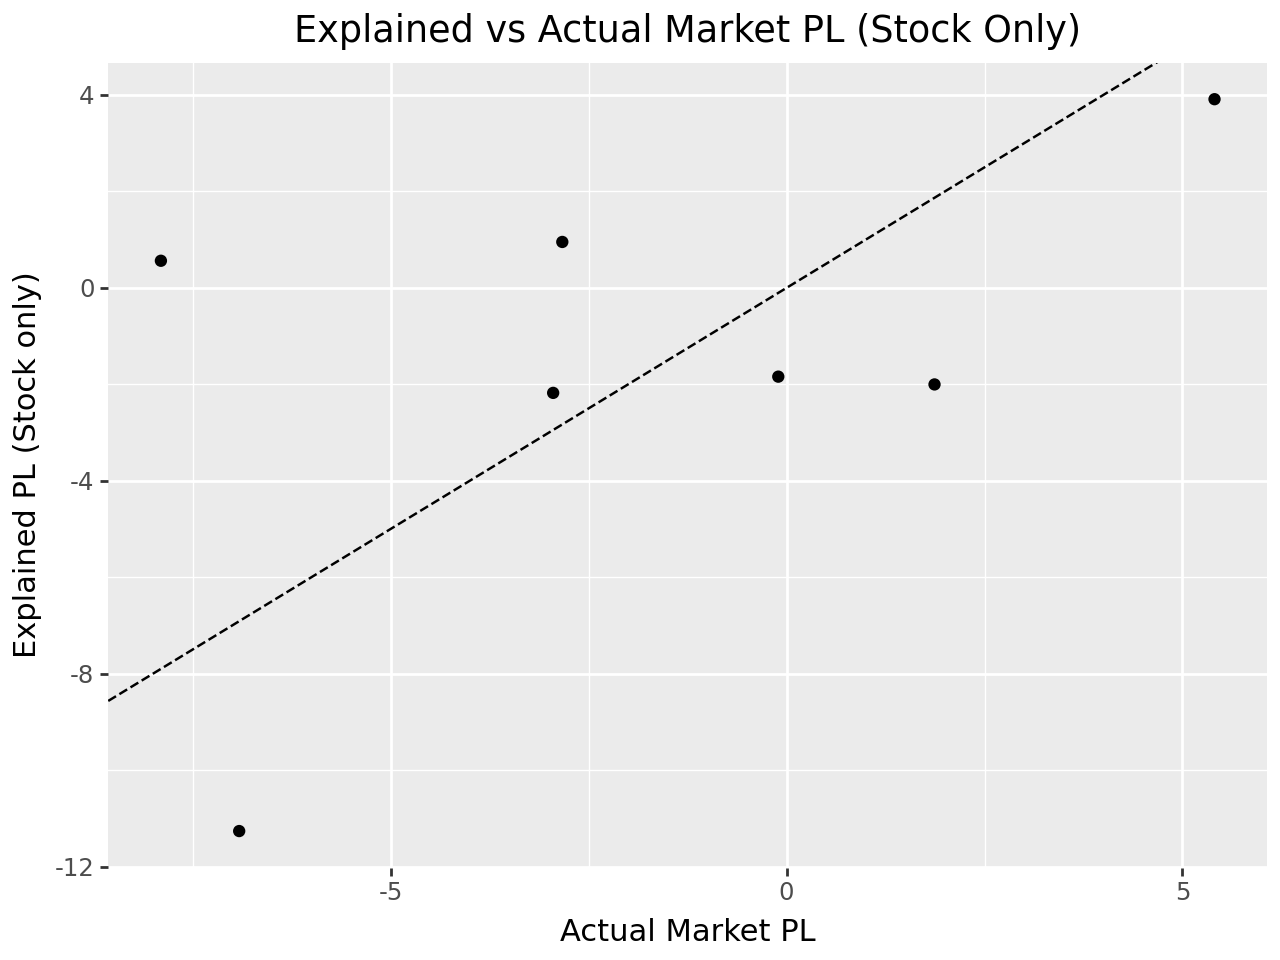

In [18]:

p_stock = (
    p9.ggplot(df_pl, p9.aes(x='Market PL', y='Explained PL (stock only)'))
    + p9.geom_point()
    + p9.geom_abline(slope=1, intercept=0, linetype='dashed')
    + p9.labs(
        title='Explained vs Actual Market PL (Stock Only)',
        x='Actual Market PL',
        y='Explained PL (Stock only)'
    )
)
p_stock


### Contribution breakdown over time

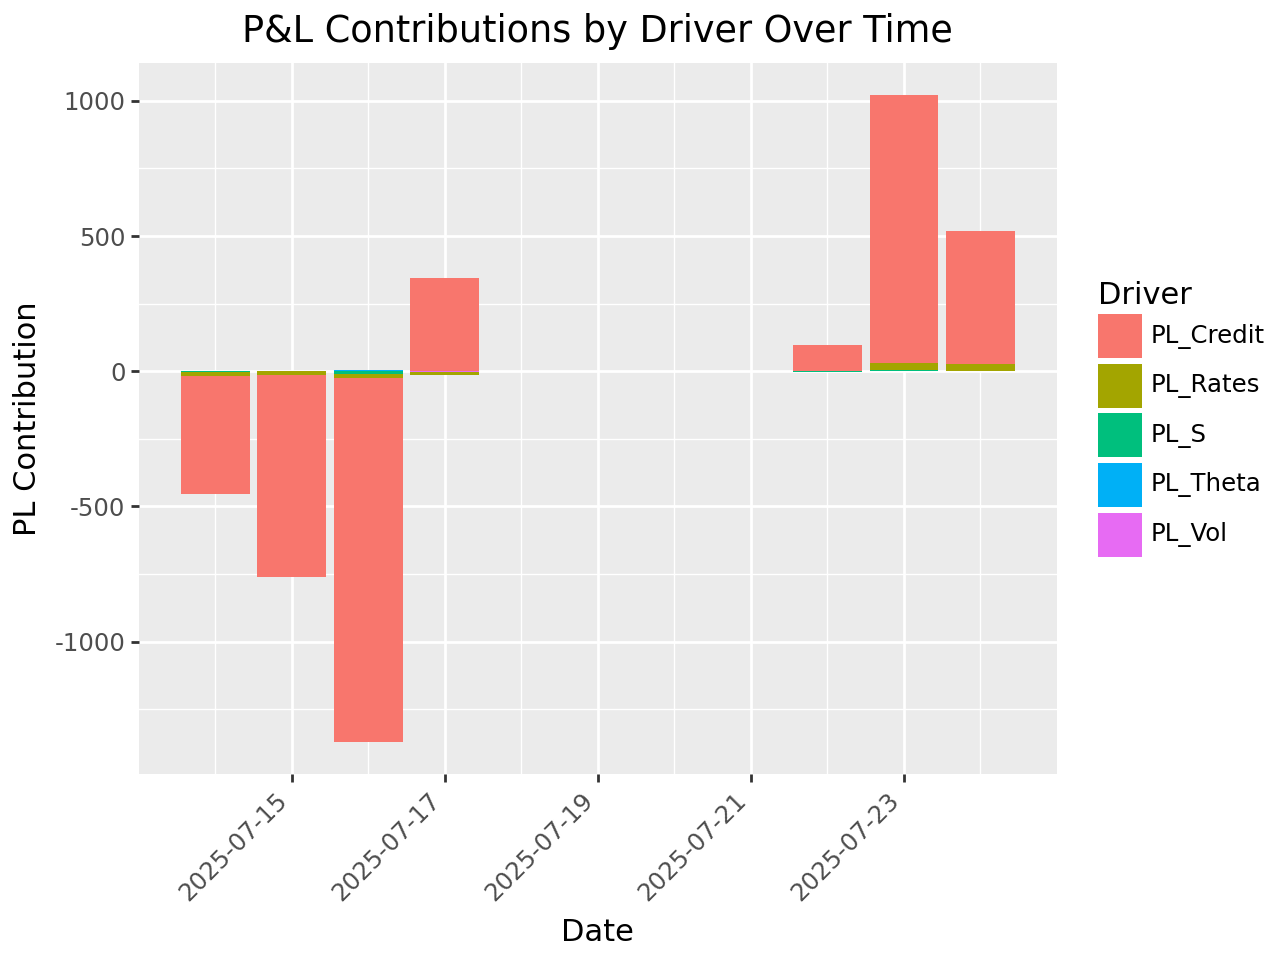

In [19]:

df_long = df_pl.melt(
    id_vars=['date'],
    value_vars=['PL_S', 'PL_Rates', 'PL_Vol', 'PL_Theta', 'PL_Credit'],
    var_name='Driver',
    value_name='PL_Contribution'
)

p_contrib = (
    p9.ggplot(df_long, p9.aes('date', 'PL_Contribution', fill='Driver'))
    + p9.geom_col(position='stack')
    + p9.labs(
        title='P&L Contributions by Driver Over Time',
        x='Date',
        y='PL Contribution'
    )
    + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
)
p_contrib


### R² diagnostics

In [20]:

import numpy as np

def r2(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

r2_all = r2(df_pl['Market PL'], df_pl['Explained PL (all drivers)'])
r2_stock = r2(df_pl['Market PL'], df_pl['Explained PL (stock only)'])

print("R^2 (all drivers):", r2_all)
print("R^2 (stock only):", r2_stock)


R^2 (all drivers): -30257.43910765301
R^2 (stock only): 0.06109769846022717


All-driver attribution should cluster closer to the identity line than stock-only. Compare the two scatter plots: if the all-driver cloud hugs the dashed line and has higher R² than the stock-only case, then rate/vol/theta/credit drivers materially improve attribution. Watch for any outlier dates with large residuals between Market PL and explained PL; these may indicate data gaps or non-modeled effects.

## 5. Sanity Checks for Prices and Greeks

In [21]:

df = details_arc.copy()

# Reasonable ranges (loose but protective)
assert df['ModelPrice'].between(800, 1200).all(), "ModelPrice outside 800–1200 range."
assert df['Convertibility Premium'].between(0, 150).all(), "Convertibility premium outside 0–150."
assert df['Underlying Price'].between(5, 50).all(), "Underlying Price for Ford looks off."

assert df['Tenor'].between(0.4, 1.5).all(), "Tenor outside 0.4–1.5 years."
assert df['Avg Risk Free Rate'].between(0.0, 0.10).all(), "Avg Risk Free Rate outside 0–10%."
assert df['Avg Volatility'].between(0.1, 0.8).all(), "Avg Volatility outside 10–80%."
assert df['Avg Hazard Rate'].between(0.0, 0.20).all(), "Avg Hazard Rate outside 0–20%."

assert df['Delta'].between(0, 150).all(), "Delta outside 0–150."
assert (df['Gamma'] > 0).all() and (df['Gamma'] < 50).all(), "Gamma not in (0, 50)."
assert (df['Vega'] > 0).all() and (df['Vega'] < 1000).all(), "Vega not in (0, 1000)."
assert (df['Rates DV01'] < 0).all(), "Rates DV01 should be negative."
assert (df['Credit DV01 (drifted)'] < 0).all(), "Credit DV01 should be negative."
assert (df['Theta'] < 0).all(), "Theta should be negative for long optional exposure."
